In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
base_dir = "D:/skin cancer dataset"
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [3]:
base_dir = "D:/skin cancer dataset"
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [4]:
image_size = (150, 150)
batch_size = 16

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',  
    shuffle=False)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',  
    shuffle=False)

Found 6666 images belonging to 2 classes.
Found 1904 images belonging to 2 classes.
Found 952 images belonging to 2 classes.


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models

def squash(x, axis=-2):
    s_squared_norm = tf.reduce_sum(tf.square(x), axis=axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm)
    return scale * x / tf.sqrt(s_squared_norm + tf.keras.backend.epsilon())

class PrimaryCaps(layers.Layer):
    def __init__(self, dim_capsule, n_channels, kernel_size, strides, padding, **kwargs):
        super(PrimaryCaps, self).__init__(**kwargs)
        self.dim_capsule = dim_capsule
        self.n_channels = n_channels
        self.conv2d = layers.Conv2D(filters=dim_capsule * n_channels, kernel_size=kernel_size,
                                    strides=strides, padding=padding)

    def call(self, inputs):
        outputs = self.conv2d(inputs)
        outputs = layers.Reshape((-1, self.dim_capsule))(outputs)
        return squash(outputs)


class DigitCaps(layers.Layer):
    def __init__(self, num_capsule, dim_capsule, routings, **kwargs):
        super(DigitCaps, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings

    def build(self, input_shape):
        self.input_num_capsule = input_shape[1]
        self.input_dim_capsule = input_shape[2]
        self.W = self.add_weight(
            shape=[self.input_num_capsule, self.num_capsule, self.input_dim_capsule, self.dim_capsule],
            initializer='glorot_uniform',
            trainable=True
        )

    def call(self, inputs):
        # inputs: [batch_size, input_num_capsule, input_dim_capsule]
        inputs_expand = tf.expand_dims(inputs, axis=2)  # [batch, input_caps, 1, input_dim]
        inputs_tiled = tf.tile(inputs_expand, [1, 1, self.num_capsule, 1])  # [batch, input_caps, output_caps, input_dim]

        # u_hat: [batch, input_caps, output_caps, output_dim]
        u_hat = tf.einsum('bijc,ijcd->bijd', inputs_tiled, self.W)

        b_ij = tf.zeros(shape=[tf.shape(inputs)[0], self.input_num_capsule, self.num_capsule, 1])

        for i in range(self.routings):
            c_ij = tf.nn.softmax(b_ij, axis=2)  # [batch, input_caps, output_caps, 1]
            s_j = tf.reduce_sum(c_ij * u_hat, axis=1, keepdims=True)  # [batch, 1, output_caps, output_dim]
            v_j = squash(s_j, axis=-1)  # same shape

            if i < self.routings - 1:
                v_j_tiled = tf.tile(v_j, [1, self.input_num_capsule, 1, 1])  # [batch, input_caps, output_caps, output_dim]
                b_ij += tf.reduce_sum(u_hat * v_j_tiled, axis=-1, keepdims=True)  # dot product along output_dim

        return tf.squeeze(v_j, axis=1)  # [batch, output_caps, output_dim]

def CapsNet(input_shape, n_class, num_routing):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (3, 3), activation='relu')(inputs)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = PrimaryCaps(8, 32, 9, 2, 'valid')(x)
    digitcaps = DigitCaps(n_class, 16, num_routing)(x)
    out_caps = layers.Lambda(lambda z: tf.sqrt(tf.reduce_sum(tf.square(z), axis=2)))(digitcaps)

    return models.Model(inputs, out_caps)

model = CapsNet(input_shape=(28, 28, 1), n_class=10, num_routing=3)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 26, 26, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ primary_caps (PrimaryCaps)           │ (None, 128, 8)              │       1,327,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ digit_caps (DigitCaps)               │ (None, 10, 16)              │         163,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 10)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,528,768 (5.83 MB)

 Trainable params: 1,528,768 (5.83 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
def build_capsule_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (3, 3), activation='relu')(inputs)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = PrimaryCaps(dim_capsule=8, n_channels=32, kernel_size=9, strides=2, padding='valid')(x)
    x = DigitCaps(num_capsule=num_classes, dim_capsule=16, routings=3)(x)
    outputs = layers.Lambda(lambda x: tf.sqrt(tf.reduce_sum(tf.square(x), axis=-1)))(x)
    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

capsule_model = build_capsule_model(image_size + (3,), 4)
capsule_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 148, 148, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 146, 146, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 73, 73, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ primary_caps_1 (PrimaryCaps)         │ (None, 34848, 8)            │       1,327,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ digit_caps_1 (DigitCaps)             │ (None, 4, 16)               │      17,842,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_1 (Lambda)                    │ (None, 4)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,208,256 (73.27 MB)

 Trainable params: 19,208,256 (73.27 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Load the pre-trained Xception model without the top layer
base_model = Xception(weights='imagenet', include_top=False,
                      input_shape=(150, 150, 3))

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)  
predictions = Dense(2, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [11]:
# Freeze all layers at first
for layer in base_model.layers:
    layer.trainable = False

In [12]:
# Compile and train initial model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), 
             tf.keras.metrics.Recall(name='recall'), 
             tf.keras.metrics.AUC(name='auc')])


In [13]:
# Train the model
history_xception = model.fit(train_generator, validation_data=validation_generator, epochs=10)

C:\Users\Dell\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
417/417 ━━━━━━━━━━━━━━━━━━━━ 375s 887ms/step - accuracy: 0.6274 - auc: 0.6588 - loss: 0.6582 - precision: 0.6232 - recall: 0.6086 - val_accuracy: 0.6670 - val_auc: 0.7379 - val_loss: 0.5989 - val_precision: 0.6651 - val_recall: 0.6675
Epoch 2/10
417/417 ━━━━━━━━━━━━━━━━━━━━ 374s 897ms/step - accuracy: 0.7428 - auc: 0.8082 - loss: 0.5343 - precision: 0.7357 - recall: 0.7287 - val_accuracy: 0.6544 - val_auc: 0.7246 - val_loss: 0.6398 - val_precision: 0.6555 - val_recall: 0.6586
Epoch 3/10
417/417 ━━━━━━━━━━━━━━━━━━━━ 369s 884ms/step - accuracy: 0.7605 - auc: 0.8332 - loss: 0.5053 - precision: 0.7582 - recall: 0.7581 - val_accuracy: 0.6586 - val_auc: 0.7309 - val_loss: 0.6259 - val_precision: 0.6647 - val_recall: 0.6465
Epoch 4/10
417/417 ━━━━━━━━━━━━━━━━━━━━ 373s 893ms/step - accuracy: 0.7619 - auc: 0.8395 - loss: 0.4936 - precision: 0.7630 - recall: 0.7520 - val_accuracy: 0.6639 - val_auc: 0.7305 - val_loss: 0.6376 - val_precision: 0.6633 - val_recall: 0.6602
Epoch 5/10
417/4

In [14]:
# Unfreeze top layers for fine-tuning
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Recompile with lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), 
             tf.keras.metrics.Recall(name='recall'), 
             tf.keras.metrics.AUC(name='auc')])



In [15]:
fine_tune_history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10
)

Epoch 1/10
417/417 ━━━━━━━━━━━━━━━━━━━━ 482s 1s/step - accuracy: 0.7406 - auc: 0.8120 - loss: 0.5398 - precision: 0.7387 - recall: 0.7448 - val_accuracy: 0.6565 - val_auc: 0.7242 - val_loss: 0.6769 - val_precision: 0.6599 - val_recall: 0.6633
Epoch 2/10
417/417 ━━━━━━━━━━━━━━━━━━━━ 469s 1s/step - accuracy: 0.7732 - auc: 0.8583 - loss: 0.4650 - precision: 0.7738 - recall: 0.7717 - val_accuracy: 0.6371 - val_auc: 0.7120 - val_loss: 0.6642 - val_precision: 0.6376 - val_recall: 0.6402
Epoch 3/10
417/417 ━━━━━━━━━━━━━━━━━━━━ 465s 1s/step - accuracy: 0.7878 - auc: 0.8755 - loss: 0.4373 - precision: 0.7894 - recall: 0.7845 - val_accuracy: 0.6439 - val_auc: 0.7228 - val_loss: 0.6919 - val_precision: 0.6427 - val_recall: 0.6471
Epoch 4/10
417/417 ━━━━━━━━━━━━━━━━━━━━ 500s 1s/step - accuracy: 0.7975 - auc: 0.8884 - loss: 0.4155 - precision: 0.7971 - recall: 0.7984 - val_accuracy: 0.6334 - val_auc: 0.7214 - val_loss: 0.6802 - val_precision: 0.6342 - val_recall: 0.6366
Epoch 5/10
417/417 ━━━━━━━━━

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_xception_model.keras', save_best_only=True)
]


In [17]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 478s 1s/step - accuracy: 0.8131 - auc: 0.9048 - loss: 0.3855 - precision: 0.8143 - recall: 0.8118 - val_accuracy: 0.6691 - val_auc: 0.7467 - val_loss: 0.6761 - val_precision: 0.6668 - val_recall: 0.6707
Epoch 2/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 470s 1s/step - accuracy: 0.8156 - auc: 0.9087 - loss: 0.3782 - precision: 0.8159 - recall: 0.8161 - val_accuracy: 0.6371 - val_auc: 0.7162 - val_loss: 0.7947 - val_precision: 0.6340 - val_recall: 0.6397
Epoch 3/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 470s 1s/step - accuracy: 0.8178 - auc: 0.9077 - loss: 0.3811 - precision: 0.8135 - recall: 0.8184 - val_accuracy: 0.6481 - val_auc: 0.7347 - val_loss: 0.7155 - val_precision: 0.6467 - val_recall: 0.6528
Epoch 4/20
417/417 ━━━━━━━━━━━━━━━━━━━━ 471s 1s/step - accuracy: 0.8211 - auc: 0.9154 - loss: 0.3645 - precision: 0.8228 - recall: 0.8189 - val_accuracy: 0.6371 - val_auc: 0.7189 - val_loss: 0.8010 - val_precision: 0.6374 - val_recall: 0.6397
Epoch 5/20
417/417 ━━━━━━━━━

In [18]:
test_loss, test_acc, test_precision, test_recall, test_auc = model.evaluate(test_generator)
print(f"\n{Xception} Test Accuracy: {test_acc}")
print(f"{Xception} Test Precision: {test_precision}")
print(f"{Xception} Test Recall: {test_recall}")
print(f"{Xception} Test AUC: {test_auc}")

60/60 ━━━━━━━━━━━━━━━━━━━━ 55s 921ms/step - accuracy: 0.8547 - auc: 0.9221 - loss: 0.3230 - precision: 0.8561 - recall: 0.8582

<function Xception at 0x000001BB8EF43EE0> Test Accuracy: 0.6911764740943909
<function Xception at 0x000001BB8EF43EE0> Test Precision: 0.6941545009613037
<function Xception at 0x000001BB8EF43EE0> Test Recall: 0.6985294222831726
<function Xception at 0x000001BB8EF43EE0> Test AUC: 0.775435745716095


In [19]:
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes
print('Confusion Matrix')
cm = confusion_matrix(y_true, y_pred)
print(cm)

60/60 ━━━━━━━━━━━━━━━━━━━━ 43s 697ms/step
Confusion Matrix
[[422  30]
 [264 236]]


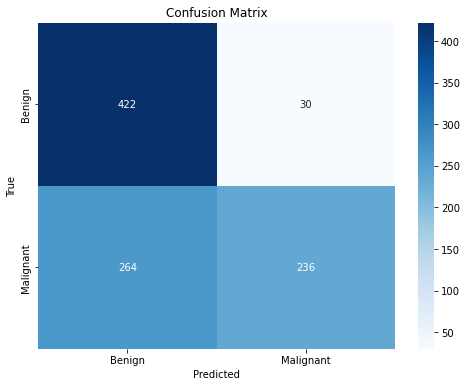

In [20]:
# Plot confusion matrix
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], 
            yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [21]:
# Classification report
target_names = ['Benign','Malignant']
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

      Benign       0.62      0.93      0.74       452
   Malignant       0.89      0.47      0.62       500

    accuracy                           0.69       952
   macro avg       0.75      0.70      0.68       952
weighted avg       0.76      0.69      0.68       952



In [23]:
# Computing the accuracy, precision, recall, and F1-score
from sklearn.metrics import classification_report, confusion_matrix,
accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"{Xception} Precision: {precision:.2f}")
print(f"{Xception} Recall: {recall:.2f}")
print(f"{Xception} F1-Score: {f1:.2f}")

<function Xception at 0x000001BB8EF43EE0> Precision: 0.76
<function Xception at 0x000001BB8EF43EE0> Recall: 0.69
<function Xception at 0x000001BB8EF43EE0> F1-Score: 0.68


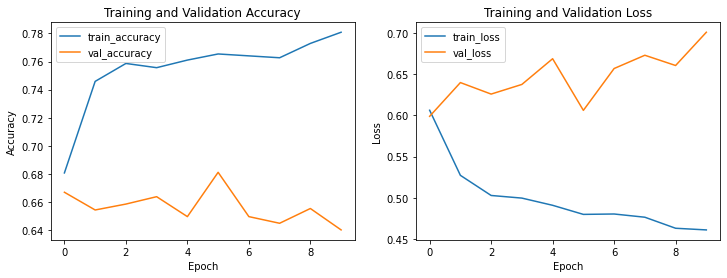

In [24]:
# Plotting training & validation accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_xception.history['accuracy'], label='train_accuracy')
plt.plot(history_xception.history['val_accuracy'], label='val_accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_xception.history['loss'], label='train_loss')
plt.plot(history_xception.history['val_loss'], label='val_loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()